# Extract and transform CFSv2 output subsets from NCEI THREDDS server

- 2021, 3/29: Successfully ran 30 days, 2019-11-01 to 2019-11-30. The server-side step (cell 11, which runs `get_subset_as_xrds`) took ~ 16 min ("CPU times: user 31 s, sys: 4.01 s, total: 35 s. Wall time: 15min 45s"). So, that's roughly 0.5 min per model day.
- 2021, 3/22: It's working again!?
- 2021: 3/10,7, 2/17,12
- 2020: 12/16, 11-16,5. https://github.com/emiliom/
- Run with conda environment https://github.com/snowmodel-tools/postprocess_python/blob/master/snowmodelaws_env.yml

Define and execute a remote request for CFSv2 model output. The user specifies the geographic bounding box (in lat-lon coordinates), the output projection (as EPSG code) and cell resolution (in meters), and the date range.

The overall approach may be grouped into several overarching steps:
1. Define the query parameters
2. Loop over each day in the requested day range
3. Dynamically construct the url for a siphon `TDSCatalog` object corresponding to a specific date (a THREDDS directory catalog)
4. Within the selected date, loop through the 4 model time steps ("cycles"), dynamically constructing the `grib2` file name and file url.
4. Execute subset and data access requests, one grib2 file at a time and returning a collection (list) of xarray datasets; one file corresponds to one timestep.
5. Concatenate the individual xarray datasets and clean up the result, simplifying the structure and adding conformant projection information.
6. Reproject and resample to the desired UTM projection.
7. Export to netcdf file

- Currently the code uses this model product: [CFSv2 Operational Analysis - 6-Hourly Surface and Radiative Fluxes (FLX)](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFSv2%20Operational%20Analysis).
- For additional background on CFSv2 see https://github.com/snowmodel-tools/preprocess_python/issues/17
- CSO GEE JavaScript code used: https://github.com/snowmodel-tools/preprocess_javascript/blob/master/define_SM_inputs.js

## TO-DOs
3/22/2021

- `snowmodelaws` env is on Py3.6 b/c of ulmo! Once I issue a new release, we'll be able to move to 3.8 or 3.9
- Add error catching to `get_subset_as_xrds`, to log and retry datasets (files) that ran into a failure during processing. The failure is typically on the NCEI TDS server end. This is the latest error, that's likely to be common:

```python
~/miniconda/envs/snowmodelaws/lib/python3.6/site-packages/siphon/http_util.py in get(self, path, params)
    485                                      'Server Error ({1:d}: {2})'.format(resp.request.url,
    486                                                                         resp.status_code,
--> 487                                                                         text))
    488         return resp
    489 

HTTPError: Error accessing https://www.ncei.noaa.gov/thredds/ncss/model-cfs_v2_anl_6h_flxf/2019/201911/20191126/cdas1.t00z.sfluxgrbf06.grib2/dataset.xml
Server Error (502: Proxy Error)
```

## CFSv2 analysis product: CFSv2 Operational Analysis 6-Hourly Products

- [Characteristics](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFSv2%20Operational%20Analysis)
    - Product: 6-Hourly Surface and Radiative Fluxes (FLX)
    - Grid/Scale: Gaussian: T574
    - Model Cycle: 4/day: 00, 06, 12, 18UTC
    - Output Timestamp: +00, +01, +02, +03, +04, +05, +06, +09
- From GEE dataset description: "We ingest only a subset of bands from files matching cdas1.t??z.sfluxgrbf06.grib2"
- For file names like `cdas1.t12z.sfluxgrbf08.grib2`, figure out what exactly is `t12z` and `f08`
- Example code pattern to use (https://github.com/nhm-usgs/gfsetl):
    ```python
    base_url = 'https://www.ncei.noaa.gov/thredds/ncss/model-gfs-g4-anl-files/'
    dt = datetime(2020, 5, 6, 0)
    ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/gfsanl_4_{dt:%Y%m%d}'
                '_{dt:%H}00_000.grb2'.format(base_url, dt=dt))
    ```
- https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf/2020/202011/20201102/catalog.html
- https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_6h_flxf/2020/202010/20201017/2020101718/catalog.html
- See the differences in time stamps and list of variables between these two datasets/files that differ only in "f" "output timestep" (`f01` vs `f06`
    - https://www.ncei.noaa.gov/thredds/ncss/model-cfs_v2_anl_6h_flxf/2020/202010/20201023/cdas1.t18z.sfluxgrbf01.grib2/dataset.html
    - https://www.ncei.noaa.gov/thredds/ncss/model-cfs_v2_anl_6h_flxf/2020/202010/20201023/cdas1.t18z.sfluxgrbf06.grib2/dataset.html
- https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf/2020/202011/20201102/catalog.html?dataset=cfs_v2_anl_6h_flxf/2020/202011/20201102/cdas1.t00z.sfluxgrbf05.grib2
- https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf/2020/202011/20201102/catalog.html?dataset=cfs_v2_anl_6h_flxf/2020/202011/20201102/cdas1.t06z.sfluxgrbf09.grib2
- https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf/2020/202011/20201102/catalog.html?dataset=cfs_v2_anl_6h_flxf/2020/202011/20201102/cdas1.t12z.sfluxgrbf08.grib2


### Generating a sequence of incremental dates
- Use `pd.date_range`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html. Will use this sequence for the date, then cycle through the 4 "model cycles" for the time: t00z, t06z, t12z, t18z
- See also https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-50.php

In [1]:
%matplotlib inline
from datetime import datetime, timedelta

import dateutil
from dateutil.parser import parse as duparse
import pandas as pd
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore
from pyproj import CRS
from rasterio.warp import Resampling
import rioxarray

## Query settings

In [2]:
tds_base_url = "https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf"

Geographical bounding box. Currently set to WY model domain.

In [3]:
geobbox = dict(
    south=42.363116,
    west=-111.155208,
    north=44.582480,
    east=-109.477849
)

geobbox_buffer_east = 1
geobbox_buffer_north = 1
# Settings from Ryan's GEE code
# geobbox_buffer_east = 0.50
# geobbox_buffer_north = 0.25

Reprojection and resampling user settings

In [4]:
to_crs = 'epsg:32612'
# to_resolution = 15000 # in meters (15 km)
to_resolution = 22200 # in meters

Date range

In [5]:
# start_date, end_date = '2020-11-05', '2020-11-07'
start_date, end_date = '2019-11-01', '2019-11-30'
# start_date, end_date = '2018-08-31 20:00', '2018-09-03'

Output file name

In [6]:
nc_export_fname = 'CFSv2_OperationalAnalysis_WY_2019-11-TEST.nc'

## Data request and filtering
Includes filtering and selection scheme.

CFSv2 variables used:

In [7]:
variable_names = [
    'Temperature_height_above_ground',
    'Geopotential_height_surface',
    'u-component_of_wind_height_above_ground',
    'v-component_of_wind_height_above_ground',
    'Pressure_surface',
    'Specific_humidity_height_above_ground',
    'Precipitation_rate_surface_6_Hour_Average',
    'Downward_Long-Wave_Radp_Flux_surface',
    'Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average',
]

In [8]:
def get_subset_as_xrds(tds_ds, var_lst, bbox):
    """ Request a geographical and variable subset for the specified dataset (one time step).
    Returns an xarray dataset.
    """
    # Interface with the data through the NetCDF Subset Service (NCSS)
    ncss = tds_ds.subset()

    # Create an NCSS query with our desired specifications
    query = ncss.query()
    query.all_times()
    query.variables(*var_lst)
    query.lonlat_box(**bbox)
    query.accept('netcdf')  # or netcdf4?

    # Use the query to obtain NetCDF data
    data = ncss.get_data(query)
    data_ds = xr.open_dataset(NetCDF4DataStore(data))
    
    return data_ds

In [9]:
def concatds_cleanup(ds_lst, crs, grid_mapping_name='crs'):
    """ Concatenate and clean up list of xarray datasets.
    Write in and clean up the CRS / `grid_mapping` attributes. Shift longitude values from 0 to 360 to -180 to +180.
    In order to be able to use `rio.reproject`, and to generate a less complex xarray dataset. Specifically:
    - Insert the information (height) into attributes in the corresponding variables, 
      from the `height_above_ground` and `height_above_ground1` variables
    - Remove (squeeze) those dimensions from the variables currently using them
    - Remove the coordinate variables themselves
    """
    
    # Assumes the data variables returned use two identical time dimensions, 'time' and 'time1'
    # Concatenate on time1, drop the orphaned time dim, then rename time1 to time
    ds = xr.concat(ds_lst, dim='time1').drop_vars('GaussLatLon_Projection')
    ds = ds.drop_dims('time').rename({'time1':'time'})
    
    ds.rio.write_crs(crs, grid_mapping_name=grid_mapping_name, inplace=True);

    # longitude rewrap
    lon_attrs = ds.lon.attrs
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    ds.lon.attrs = lon_attrs

    # height_above_ground simplification
    height_dim_names = ['height_above_ground', 'height_above_ground1']
    for dim_name in height_dim_names:
        for data_var_name in ds.data_vars:
            data_var = ds[data_var_name]
            if dim_name in ds[data_var_name].dims:
                data_var.attrs['height_above_ground'] = "{:.1f}m".format(ds[dim_name].values[0])
                ds[data_var_name] = data_var.squeeze(dim_name, drop=True)

    # TODO: Update the variable coords attribute, for consistency
    
    ds = ds.squeeze(height_dim_names, drop=True)
    
    return ds

### Construct and execute the query

Step through days in the date range, setting the `TDSCatalog` for each day, then stepping through the 4 model time steps ("model cycles"). The path to the `TDSCatalog` is constructed dynamically based on the date; the path to each `grib2` dataset is also constructed dynamically.

In [10]:
# Create a sligthly larger box for the data query, relative to geobbox
buffered_geobbox = geobbox.copy()
buffered_geobbox['south'] = geobbox['south'] - geobbox_buffer_north
buffered_geobbox['north'] = geobbox['north'] + geobbox_buffer_north
buffered_geobbox['west'] = geobbox['west'] - geobbox_buffer_east
buffered_geobbox['east'] = geobbox['east'] + geobbox_buffer_east

https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_anl_6h_flxf/2018/201808/20180831/catalog.html?dataset=cfs_v2_anl_6h_flxf/2018/201808/20180831/cdas1.t00z.sfluxgrbf06.grib2

https://www.ncei.noaa.gov/thredds/ncss/model-cfs_v2_anl_6h_flxf/2018/201808/20180831/cdas1.t00z.sfluxgrbf06.grib2/dataset.xml

In [11]:
%%time

data_ds_lst = []
for day in pd.date_range(start=start_date, end=end_date):
    print(day)
    cfsv2_cat = TDSCatalog(f"{tds_base_url}/{day:%Y}/{day:%Y%m}/{day:%Y%m%d}/catalog.xml")
    # NOTE: THIS SCHEME WILL PULL ENTIRE DAYS' WORTH OF DATA; IT DOES NOT REFINE THE QUERY BY TIME
    # Step through time steps (UTC times)
    fts = 6
    for t in [0, 6, 12, 18]:
        grb2_fname = f"cdas1.t{t:02d}z.sfluxgrbf{fts:02d}.grib2"
        print(f"    {grb2_fname}")
        grb2_tds = cfsv2_cat.datasets[grb2_fname]
        xrds = get_subset_as_xrds(grb2_tds, variable_names, buffered_geobbox)
        for v in variable_names:
            # Most of the variables are assigned time1, so it should be more efficient to do the rename on 'time'
            if 'time' in xrds[v].dims:
                xrds[v] = xrds[v].rename({'time': 'time1'})
        
        data_ds_lst.append(xrds)

2019-11-01 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-02 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-03 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-04 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-05 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-06 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
    cdas1.t12z.sfluxgrbf06.grib2
    cdas1.t18z.sfluxgrbf06.grib2
2019-11-07 00:00:00
    cdas1.t00z.sfluxgrbf06.grib2
    cdas1.t06z.sfluxgrbf06.grib2
  

- 2020-11-13 2:45pm: `date_range(start='2020-11-1', end='2020-11-10')` took 5min 36s:
    ```
    CPU times: user 7.13 s, sys: 933 ms, total: 8.06 s
    Wall time: 5min 36s
    ```
- 2020-11-13 7pm: `date_range(start='2020-10-1', end='2020-11-10')` took 24min:
    ```
    CPU times: user 33.5 s, sys: 4.34 s, total: 37.8 s
    Wall time: 24min
    ```

The concatenation step assumes the datasets in `data_ds_lst` were added in ascending chronological order, which has been the case so far.

In [12]:
len(data_ds_lst)

120

In [13]:
data_ds = concatds_cleanup(data_ds_lst, crs='epsg:4326')
data_ds

<xarray.Dataset>
Dimensions:                                                    (lat: 21, lon: 19, time: 120)
Coordinates:
  * time                                                       (time) datetime64[ns] ...
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
    crs                                                        int64 0
Data variables:
    v-component_of_wind_height_above_ground                    (time, lat, lon) float32 ...
    Precipitation_rate_surface_6_Hour_Average                  (time, lat, lon) float32 ...
    u-component_of_wind_height_above_ground                    (time, lat, lon) float32 ...
    Specific_humidity_height_above_ground                      (time, lat, lon) float32 ...
    Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average  (time, lat, lon) float32 ...
    Downward_Long-Wave_Radp_Flux_surface                       (time, lat, lon) float32 ...
    Temperature_height_above_ground                            (time, lat, lon) float32 ...
    Pressure_surface                                           (time, lat, lon) float32 ...
    Geopotential_height_surface                                (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    grid_mapping:                                                            ...

### Explore the resulting dataset

In [14]:
def print_cellsizes(dimcoord, i):
    return dimcoord.values[i+1] - dimcoord.values[i]

print_cellsizes(data_ds.lon, 0), print_cellsizes(data_ds.lat, 0), print_cellsizes(data_ds.lat, 1)

(0.20455933, -0.20442963, -0.20442963)

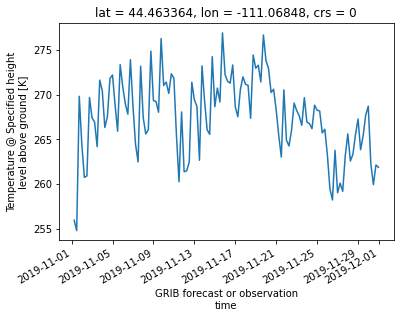

In [15]:
# data_ds['Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average'].isel(lon=1, lat=1).plot();
data_ds['Temperature_height_above_ground'].isel(lon=5, lat=5).plot();

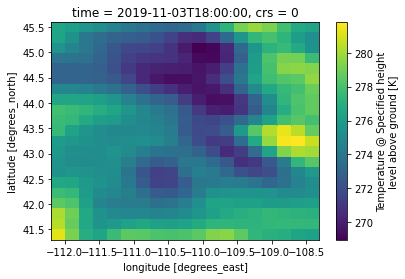

In [16]:
# data_ds.Temperature_height_above_ground.sel(time='2020-10-19 07:00', method="nearest").plot();
data_ds.Temperature_height_above_ground.isel(time=10).plot();

## Reproject and resample dataset

In [17]:
x_name = 'easting'
y_name = 'northing'

In [18]:
# resampling=Resampling.bilinear
data_reproj_ds = data_ds.rio.reproject(to_crs, resolution=to_resolution, resampling=Resampling.nearest)
data_reproj_ds = (
    data_reproj_ds
    .rio.set_spatial_dims('x', 'y')
    .rename({"x": x_name, "y": y_name}) 
)

data_reproj_ds[x_name].attrs['long_name'] = 'Easting'
data_reproj_ds[y_name].attrs['long_name'] = 'Northing'

In [19]:
data_reproj_ds

<xarray.Dataset>
Dimensions:                                                    (easting: 15, northing: 22, time: 120)
Coordinates:
  * easting                                                    (easting) float64 ...
  * northing                                                   (northing) float64 ...
  * time                                                       (time) datetime64[ns] ...
    crs                                                        int64 0
Data variables:
    v-component_of_wind_height_above_ground                    (time, northing, easting) float32 ...
    Precipitation_rate_surface_6_Hour_Average                  (time, northing, easting) float32 ...
    u-component_of_wind_height_above_ground                    (time, northing, easting) float32 ...
    Specific_humidity_height_above_ground                      (time, northing, easting) float32 ...
    Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average  (time, northing, easting) float32 ...
    Downward_Long-Wave_Radp_Flux_surface                       (time, northing, easting) float32 ...
    Temperature_height_above_ground                            (time, northing, easting) float32 ...
    Pressure_surface                                           (time, northing, easting) float32 ...
    Geopotential_height_surface                                (time, northing, easting) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    grid_mapping:                                                            ...

**NOTE:** When the reprojected resolution was set to 20km (possibly coarser than the original resolution), some cells were set to the `_FillValue` but xarray didn't seem to properly apply the `_FillValue`.

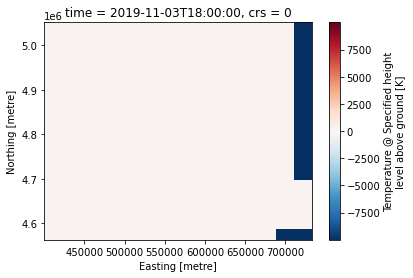

In [20]:
# data_reproj_ds.Temperature_height_above_ground.sel(time='2020-10-19 07:00', method="nearest").plot();
data_reproj_ds.Temperature_height_above_ground.isel(time=10).plot();

## Export to netcdf

Can easily export to netcdf

In [21]:
data_reproj_ds.to_netcdf(nc_export_fname)